# 2023 Lazard Data Science Technical Test
# Predicting stock returns using news headline and sentiment
## By Grace Yang


The notebook contains data loading and preprocessing code.

## Load packages

In [101]:
import  warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')




[nltk_data] Downloading package stopwords to /Users/yge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load datasets (csv, h5, xlsx files)

In [102]:

X_PATH = 'x_df_comp_factors.h5'
Y_PATH = 'y_series_return.h5'
NEWS_PATH = 'consumer_comp_news_sentiment.csv'
CLEANED_X_PATH = 'cleaned_comp_factors.csv'
CLEANED_Y_PATH = 'cleaned_y_series_return.csv'
CLEANED_NEWS_PATH = 'cleaned_consumer_comp_news_sentiment.csv'
MAPIING_PATH = 'rp_full_ticker_mapping.xlsx'



def preprocess_h5():
    x_df = pd.read_hdf(X_PATH)
    y_df = pd.read_hdf(Y_PATH)
    x_df.columns = x_df.columns.str.lower()
    y_df.columns = y_df.columns.str.lower()
    x_df = exclude_month(x_df, 'date')
    y_df = exclude_month(y_df, 'date')
    x_df.to_csv(CLEANED_X_PATH, index=False)
    y_df.to_csv(CLEANED_Y_PATH, index=False)


# only keep data that has corresponding target labels.
def exclude_month(df, date_col_name):
    df = df.loc[~((df[date_col_name] >= '2001-02-01') & (df[date_col_name] <= '2013-12-31') | 
              (df[date_col_name] >= '2023-09-01') & (df[date_col_name] <= '2023-10-31'))]
    return df


def preprocess_news():
    company_news = pd.read_csv(NEWS_PATH)
    company_news.columns = company_news.columns.str.lower()
    company_news = exclude_month(company_news, 'timestamp_utc')
    company_news.drop_duplicates(inplace = True)
    company_news.to_csv(CLEANED_NEWS_PATH, index=False)


preprocess_news()
preprocess_h5()



# comp_factors.csv: (6611, 62) -> (3140, 62)
# y_series_return.csv: (6611, 3) -> (3140, 3)
# consumer_comp_news_sentiment.csv: (55488, 12) -> (51478, 12)
# rp_full_ticker_mapping.xlsx: (25, 3)

## Load all datasets

In [103]:
comp_factors = pd.read_csv(CLEANED_X_PATH)
y_series_return = pd.read_csv(CLEANED_Y_PATH)
company_news = pd.read_csv(CLEANED_NEWS_PATH)
mapping = pd.read_excel(MAPIING_PATH)

`company_news` Includes the relevant news of the 25 companies from 01/2020 to 10/2023. 

In [104]:
company_news

,timestamp_utc,rp_entity_id,entity_name,relevance,topic,group,type,sub_type,event_relevance,event_sentiment_score,event_text,headline
0,2020-01-02 03:51:15.034,067779,Carnival Corp.,100,business,products-services,business-contract,NaN,100,0.49,"Galveston, Carnival Cruise Lines sign contract","Port Galveston, Carnival Cruise Lines sign con..."
1,2020-01-02 05:39:46.961,1BC12C,General Motors Co.,100,business,revenues,revenue,down,100,-0.60,Gm Korea's Dec. sales dip 8.5 pct on lower,GM Korea's Dec. sales dip 8.5 pct on lower demand
2,2020-01-02 06:37:37.082,1BC12C,General Motors Co.,100,business,revenues,revenue,down,100,-0.60,Gm Koreas Dec. sales dip 8.5 pct on lower,GM Koreas Dec. sales dip 8.5 pct on lower demand
3,2020-01-02 10:13:00.110,3CBA2A,Starbucks Corp.,100,business,acquisitions-mergers,company-for-sale,NaN,100,-0.57,Starbucks sells for $1.3M,Dayton-area Starbucks sells for $1.3M
4,2020-01-02 11:15:40.500,8C6C1B,Ross Stores Inc.,100,business,analyst-ratings,analyst-ratings-change,negative,100,-0.58,Wells Fargo analyst Ike Boruchow downgraded Ro...,Ross Stores downgraded to Equal Weight from Ov...
...,...,...,...,...,...,...,...,...,...,...,...,...
51473,2023-08-31 20:45:11.614,385DD4,Marriott International Inc.,100,business,analyst-ratings,analyst-ratings-change,neutral,100,0.00,"On August 31, 2023, Citigroup maintained cover...","Citigroup Maintains Marriott International, In..."
51474,2023-08-31 20:46:32.675,DC2B00,Dollar General Corp.,100,business,labor-issues,executive-appointment,NaN,100,0.47,Dollar General promotes Rod West to executive ...,Dollar General promotes Rod West to executive ...
51475,2023-08-31 21:01:37.655,385DD4,Marriott International Inc.,100,business,products-services,business-contract,NaN,100,0.49,"Marriott International, Inc., today announced ...",Marriott International Signs Agreement to Brin...
51476,2023-08-31 21:06:03.407,385DD4,Marriott International Inc.,100,business,products-services,business-contract,NaN,100,0.49,"Marriott International, Inc., today announced ...",Marriott International Signs Agreement to Brin...


- `comp_factors` Includes financial metrics for a comprehensive view of a company's financial health, performance, and risk profile. 

In [105]:
comp_factors

,security,date,trail_12m_net_sales,trail_12m_eps,trail_12m_oper_margin,ev_to_t12m_ebitda,enterprise_value,best_pe_ratio,px_last,best_sales,...,bs_mkt_sec_other_st_invest,bs_cur_liab,bs_acct_note_rcv,is_operating_expn,invent_days,acct_rcv_days,accounts_payable_turnover_days,wacc_eva_spread,wacc_return_on_inv_capital,wacc
0,AMZN US Equity,2000-01-31,1639.84,-1.1800,-24.8902,NaN,27049.4,NaN,64.563,NaN,...,589.226,738.935,0.0,170.026,33.8364,NaN,68.2801,NaN,NaN,NaN
1,AMZN US Equity,2000-02-29,1639.84,-1.1800,-24.8902,NaN,27049.4,NaN,68.875,NaN,...,589.226,738.935,0.0,170.026,33.8364,NaN,68.2801,NaN,NaN,NaN
2,AMZN US Equity,2000-03-31,1920.08,-1.4150,-28.7724,NaN,24591.3,NaN,67.000,NaN,...,924.794,567.165,0.0,324.007,25.4143,NaN,42.0249,NaN,NaN,NaN
3,AMZN US Equity,2000-04-28,1920.08,-1.4150,-28.7724,NaN,24591.3,NaN,55.188,NaN,...,924.794,567.165,0.0,324.007,25.4143,NaN,42.0249,NaN,NaN,NaN
4,AMZN US Equity,2000-05-31,1920.08,-1.4150,-28.7724,NaN,24591.3,NaN,48.313,NaN,...,924.794,567.165,0.0,324.007,25.4143,NaN,42.0249,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155,YUM US Equity,2023-04-28,6940.00,4.3958,31.7147,20.6842,48380.4,26.520,140.580,7400.33,...,0.000,1555.000,622.0,719.000,NaN,31.2143,NaN,-406.6750,-399.6840,6.9915
3156,YUM US Equity,2023-05-31,6940.00,4.3958,31.7147,21.0023,49124.4,24.281,128.690,7464.29,...,0.000,1555.000,622.0,719.000,NaN,31.2143,NaN,341.1810,348.1270,6.9459
3157,YUM US Equity,2023-06-30,6940.00,4.3958,31.7147,21.0023,49124.4,26.097,138.550,7468.20,...,0.000,1555.000,622.0,719.000,NaN,31.2143,NaN,171.0190,177.9650,6.9459
3158,YUM US Equity,2023-07-31,6991.00,4.8185,31.7551,21.4517,50669.0,25.054,137.670,7593.94,...,0.000,1487.000,656.0,699.000,NaN,32.7357,NaN,40.7269,48.6015,7.8746


`y_series_return` Includes two objective series to predict-monthly price returns and 1-month forward
price returns of the companies.

In [106]:
y_series_return

,security,date,monthly_return,monthly_return_f1
0,AMZN US Equity,2000-01-31,NaN,0.066787
1,AMZN US Equity,2000-02-29,0.066787,-0.027223
2,AMZN US Equity,2000-03-31,-0.027223,-0.176299
3,AMZN US Equity,2000-04-28,-0.176299,-0.124574
4,AMZN US Equity,2000-05-31,-0.124574,-0.248380
...,...,...,...,...
3155,YUM US Equity,2023-04-28,0.064355,-0.084578
3156,YUM US Equity,2023-05-31,-0.084578,0.076618
3157,YUM US Equity,2023-06-30,0.076618,-0.006351
3158,YUM US Equity,2023-07-31,-0.006351,-0.060216


`mapping` Includes the ID mapping (`RP_ENTITY_ID` <-> `security`) between the news dataset
and other tables.

In [107]:
mapping

,RP_ENTITY_ID,security,ticker
0,0157B1,AMZN US Equity,AMZN
1,64CEBB,APTV US Equity,APTV
2,ECF709,AZO US Equity,AZO
3,034B61,BKNG US Equity,BKNG
4,067779,CCL US Equity,CCL
5,A63820,CMG US Equity,CMG
6,DC2B00,DG US Equity,DG
7,972356,EBAY US Equity,EBAY
8,A6213D,F US Equity,F
9,1BC12C,GM US Equity,GM


## Aggregation
- The time unit of each row is `date`, to combine features `X` with its corresponding target `y` that has month as time unit (monthly return and next month's return), we need to aggregate `X` by company and by year and month.
- the weighted_sentiment_scores is the `event_sentiment_score` weighted by `event_relevance`
- incorporate category of news event with increasing granularity into the `headline` as context information. 
- news headlines with contexts are concatenated and aggregated by company and by year_month. Other features are aggregated by taking the mean of the aggregated group.

In [108]:
def aggregate_factors(comp_factors):
    comp_factors['y_m'] = comp_factors['date'].apply(lambda x: x[:7])
    comp_factors.drop('date', axis = 1, inplace = True)
    aggre_factors = comp_factors.groupby(['security', 'y_m']).mean()
    aggre_factors.reset_index(inplace=True)
    #aggre_factors.to_csv('agg_factors.csv', index = False)
    return aggre_factors
aggre_factors = aggregate_factors(comp_factors)

In [109]:
def aggregate_news(company_news):
    company_news['y_m'] = company_news['timestamp_utc'].apply(lambda x: x[:7])
    company_news['weighted_sentiment_score'] = company_news['event_sentiment_score'] * company_news['event_relevance']/100
    company_news['news_context'] = company_news.apply(lambda x: ', '.join([x['topic'], x['group'], x['type']]), axis=1)
    company_news['context_with_headline'] = company_news.apply(lambda x: ' '.join([x['news_context'], x['headline']]), axis =1 )
    summary_company_news = company_news[['y_m','rp_entity_id', 'entity_name',  'weighted_sentiment_score','context_with_headline' ]]
    month_company_agg = summary_company_news.groupby(['y_m', 'rp_entity_id','entity_name' ]).agg({'weighted_sentiment_score': 'mean', 'context_with_headline': lambda x: ','.join(x[::-1])})
    month_company_agg.reset_index(inplace=True)
    return month_company_agg

month_company_agg = aggregate_news(company_news)


To deal with the texts in the `context_with_headline` feature
- I extract tfidf embeddings of the `n(40)` most frequent words from the entire headline corpus.
- I manually remove stop words and company identifying words from the selected vocab list to ensure a more representative vocabulary.
- concatenate the tfidf embeddings with other features.


In [110]:
def tfidf_embeddings(n):
    stop_words = set(stopwords.words('english'))
    texts = month_company_agg['context_with_headline'].to_list()
    words = ' '.join(texts).replace(',', ' ').replace('.', ' ').replace('-', ' ').split()
    word_freq = Counter(words)
    top_n_words = [i[0] for i in word_freq.most_common(n)]
    company_name = ['amazon', 'ford', 'target', 'inc', 'gm']
    filtered_words = [word.lower() for word in top_n_words if word.lower() not in stop_words and word.lower() not in company_name]
    #print(filtered_words)

    vocab = list(set(filtered_words))
    texts = month_company_agg['context_with_headline'].to_list()
    tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)
    tfidf_embeddings = tfidf_vectorizer.fit_transform(texts)
    tfidf_embeddings_array = tfidf_embeddings.toarray()
    return pd.DataFrame(tfidf_embeddings_array, columns = vocab)
tfidf_df = tfidf_embeddings(40)


In [111]:
def add_tfidf_to_df(month_company_agg, tfidf_df):
    month_company_agg = month_company_agg.join(tfidf_df)
    month_company_agg.drop('context_with_headline', axis = 1, inplace = True)
    month_company_agg = month_company_agg.merge(mapping, how= 'left', left_on='rp_entity_id', right_on='RP_ENTITY_ID').drop('RP_ENTITY_ID', axis = 1)
    #month_company_agg.to_csv('month_company_agg.csv', index = False)
    return month_company_agg
month_company_agg = add_tfidf_to_df(month_company_agg, tfidf_df)

## few more steps in feature engineering
- remove company identifying features relevant for model prediction. 
- drop features that have all `nan` values
- extract `year`, `month`, `year_bin` features from the `date` feature
- the resulting feature df now has 91 features. 

In [112]:

#month_company_agg = pd.read_csv('month_company_agg.csv')
#aggre_factors = pd.read_csv('agg_factors.csv')
y_series_return['y_m'] = y_series_return['date'].apply(lambda x: x[:7])
x_y = aggre_factors.merge(month_company_agg, how = 'left', on=['y_m', 'security'])
combined = x_y.merge(y_series_return, on = ['y_m', 'security'])
combined.drop(['date'], axis = 1, inplace= True)
combined = combined[(~combined['monthly_return'].isna())&(~combined['monthly_return_f1'].isna())]


combined['y_m'] = pd.to_datetime(combined['y_m'])
combined['year'] = combined['y_m'].dt.year
combined['month'] = combined['y_m'].dt.month
bins = list(range(combined['year'].min(), combined['year'].max() + 6, 5))
combined['year_bin'] = pd.cut(combined['year'], bins=bins, right=False)
le = LabelEncoder()
combined['year_bin'] = le.fit_transform(combined['year_bin'])
combined['entity_name']= le.fit_transform(combined['entity_name'])
combined.drop(['y_m', 'rp_entity_id',  'ticker', 'security', 'px_last_usd'], axis = 1, inplace=True)
combined.dropna(axis=1, how='all', inplace = True)

combined.to_csv('combined.csv', index = False)
#combined = pd.read_csv('combined.csv')
combined

,trail_12m_net_sales,trail_12m_eps,trail_12m_oper_margin,ev_to_t12m_ebitda,enterprise_value,best_pe_ratio,px_last,best_sales,best_eps,best_cur_ev_to_ebitda,...,equity,release,labor,business,actions,monthly_return,monthly_return_f1,year,month,year_bin
1,1639.84,-1.1800,-24.8902,NaN,27049.4,NaN,68.875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.066787,-0.027223,2000,2,0
2,1920.08,-1.4150,-28.7724,NaN,24591.3,NaN,67.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.027223,-0.176299,2000,3,0
3,1920.08,-1.4150,-28.7724,NaN,24591.3,NaN,55.188,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.176299,-0.124574,2000,4,0
4,1920.08,-1.4150,-28.7724,NaN,24591.3,NaN,48.313,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.124574,-0.248380,2000,5,0
5,2183.58,-1.4900,-28.4537,NaN,14147.1,NaN,36.313,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.248380,-0.170407,2000,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155,6940.00,4.3958,31.7147,20.6842,48380.4,26.520,140.580,7400.33,5.301,19.254,...,0.048130,0.000000,0.047242,0.649022,0.044059,0.064355,-0.084578,2023,4,3
3156,6940.00,4.3958,31.7147,21.0023,49124.4,24.281,128.690,7464.29,5.300,18.079,...,0.000000,0.055221,0.000000,0.541581,0.000000,-0.084578,0.076618,2023,5,3
3157,6940.00,4.3958,31.7147,21.0023,49124.4,26.097,138.550,7468.20,5.309,19.105,...,0.105104,0.169287,0.041267,0.701910,0.096215,0.076618,-0.006351,2023,6,3
3158,6991.00,4.8185,31.7551,21.4517,50669.0,25.054,137.670,7593.94,5.495,18.562,...,0.055145,0.148033,0.108257,0.637392,0.050481,-0.006351,-0.060216,2023,7,3


## Visualization:

- Correlation between features and labels

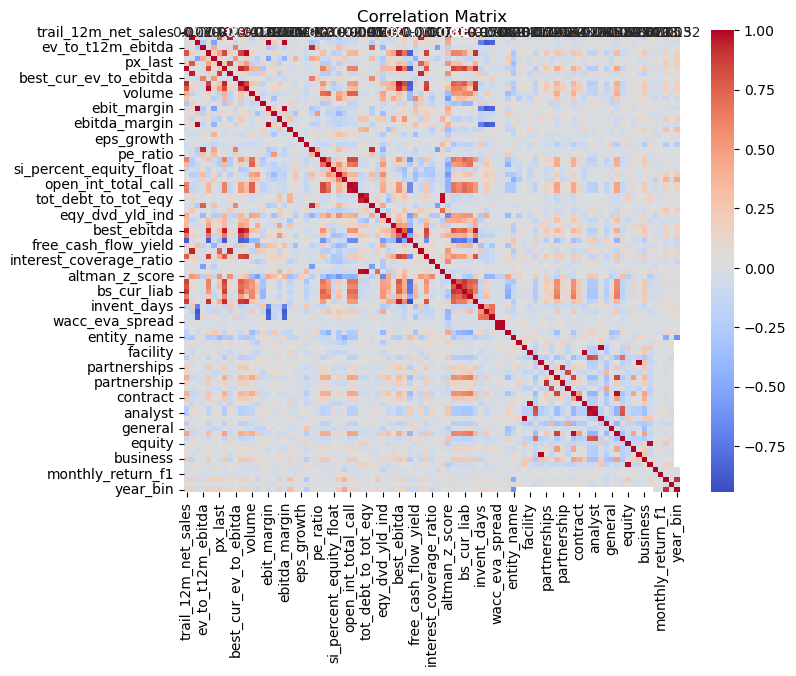

In [113]:
corr_matrix = combined.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [96]:
# Get the top n=10 correlations with monthly_return
correlations = combined.corrwith(combined['monthly_return'])
n = 10 
top_correlations = correlations.abs().nlargest(n+1)[1:]
print("Top", n, "correlations with respect to monthly return:")
print(top_correlations)

Top 10 correlations with respect to column A:
ivol_delta                  0.180864
eqy_dvd_yld_ind             0.170164
weighted_sentiment_score    0.115912
t12_fcf_t12_ebitda          0.094006
eqy_dvd_yld_12m             0.085749
return_com_eqy              0.077176
best_pe_ratio               0.076531
altman_z_score              0.074128
open_int_total_call         0.068713
price                       0.067884
dtype: float64


In [97]:
# Get the top n=10 correlations with monthly_return_f1
correlations = combined.corrwith(combined['monthly_return_f1'])
n = 10 
top_correlations = correlations.abs().nlargest(n+1)[1:]
print("Top", n, "correlations with respect to monthly return:")
print(top_correlations)

Top 10 correlations with respect to monthly return:
ivol_delta                   0.110404
rsk_bb_implied_cds_spread    0.090767
return_com_eqy               0.087689
release                      0.076317
earnings                     0.062665
monthly_return               0.060237
sales_growth                 0.059095
tot_debt_to_com_eqy          0.052108
month                        0.051086
t12_fcf_t12_ebitda           0.050324
dtype: float64


These output features might be very useful for the regression tasks.

Visualize weighted sentiment_score distribution: the distribution of sentiment scores is quite symmetrics.

Text(0.5, 1.0, 'Histogram of weighted_sentiment_score')

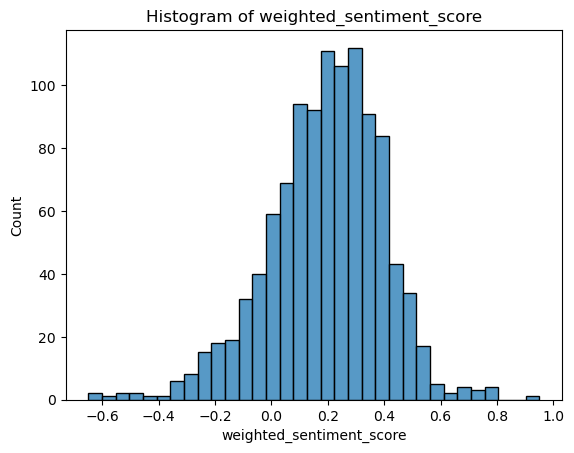

In [114]:
ax = sns.histplot(data=combined, x='weighted_sentiment_score')
ax.set_title('Histogram of weighted_sentiment_score')

## Split dataset into features(`X`) and labels(`y`)
- experiment: consider dataset that only contains news headline and sentiment scores (three years) vs the entire dataset(2000-2023)
- (optional) consider dimensional reduction/ feature selection using wrapper method for the most useful `n(30)` features

In [63]:

# wrapper methods to select features
#combined = pd.read_csv('combined.csv')

def xy_split(combined, headline_only = False, feature_select = False):
    if headline_only:
        combined = combined[~combined['equity'].isna()]
        combined.reset_index(inplace = True, drop = True)
    X = combined.drop(['monthly_return','monthly_return_f1'], axis = 1)
    y1 = combined['monthly_return']
    y2 = combined['monthly_return_f1']
    selected_features = None

    if feature_select:
        imputer = SimpleImputer(strategy='mean')
        X_imputed = pd.DataFrame(imputer.fit_transform(X))
        estimator = LinearRegression()
        selector = RFE(estimator, n_features_to_select=30, step=1)
        selector = selector.fit(X_imputed, y1)
        print(selector.support_)
        #selected_features = X.columns[selector.support_]
        print(selected_features)

    return X, y1, y2, selected_features




## Baseline xgboost model with tfidf(top n) features:
- The performance is pretty unsatisfactory. 
- though more work can be done with hyperparameter search, it seems that it would bring limited performance lift.

In [117]:
# scale of y too small, multiply by 100

def xgboost_exp(X, y):

    X_train, X_valid, y_train, y_valid = train_test_split(X, 100*y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor()
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, 5],
        'learning_rate': [0.1, 0.3, 0.01]
    }


    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Output feature importance
    importance = best_model.feature_importances_
    feature_names = X_train.columns
    feature_importance = list(zip(feature_names, importance))


    # Make predictions and calculate evaluation metrics
    y_pred = best_model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)

    print(f'Mean Squared Error (MSE):', mse)
    print(f'R-squared (R2) score:', r2)
    return mse, r2, feature_importance


names = ['task 1 on not headline only data (entire data)', 'task 2 on not headline only data',
         'task 1 on headline only data', 'task 2 on headline only data']

X, y1, y2, selected_features = xy_split(combined)

print(names[0])
r1 = xgboost_exp(X, y1)




task 1 on not headline only data (entire data)


/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

Mean Squared Error (MSE): 85.10209250191322
R-squared (R2) score: 0.07871246264624487


In [118]:
X, y1, y2, selected_features = xy_split(combined)
print(names[1])
r2 = xgboost_exp(X, y2)


task 2 on not headline only data


/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/y

Mean Squared Error (MSE): 109.28091277444825
R-squared (R2) score: 0.025353220412455912


In [119]:
X, y1, y2, selected_features = xy_split(combined, headline_only = True)
print(names[2])
r3 = xgboost_exp(X, y1)


task 1 on headline only data


/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

Mean Squared Error (MSE): 159.0861060762076
R-squared (R2) score: 0.0719598510423276


In [120]:
print(names[3])
r4= xgboost_exp(X, y2)

task 2 on headline only data


/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/yge/miniconda3/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/y

Mean Squared Error (MSE): 102.85104570458397
R-squared (R2) score: 0.1394458499720307


Check an example of feature importance output by xgboost

In [121]:
print('Task 1 feature importance by xgboost')
feature_importance = sorted(r1[2], key=lambda x: x[1], reverse=True)
for feature, score in feature_importance:
    print('{}: {}'.format(feature, score))


Task 1 feature importance by xgboost
return_com_eqy: 0.03996151313185692
best_eps: 0.039907168596982956
eqy_dvd_yld_ind: 0.02910389006137848
cur_mkt_cap: 0.02607518807053566
open_int_total_call: 0.02559521235525608
ivol_delta: 0.02532036602497101
px_to_book_ratio: 0.023382795974612236
tot_debt_to_com_eqy: 0.023089714348316193
enterprise_value: 0.022765127941966057
current_ev_to_t12m_ebitda: 0.022722525522112846
analyst: 0.02172955498099327
partnership: 0.019197316840291023
revenue: 0.018475240096449852
pe_ratio: 0.017750447615981102
best_estimate_fcf: 0.01729467138648033
revenues: 0.016168858855962753
best_cur_ev_to_ebitda: 0.015538802370429039
price: 0.015527245588600636
eqy_sh_out: 0.015409331768751144
ev_to_t12m_ebitda: 0.014478405937552452
wacc: 0.01417982205748558
best_ebitda: 0.013850484043359756
eqy_dvd_yld_12m: 0.013220250606536865
best_sales: 0.013133801519870758
altman_z_score: 0.013100756332278252
wacc_return_on_inv_capital: 0.013023926876485348
open_int_total_put: 0.0129231

In [122]:

print('Task 2 feature importance by xgboost')
feature_importance2 = sorted(r2[2], key=lambda x: x[1], reverse=True)
for feature, score in feature_importance2:
    print('{}: {}'.format(feature, score))

Task 2 feature importance by xgboost
return_com_eqy: 0.06948203593492508
t12_fcf_t12_ebitda: 0.0611400380730629
business: 0.058627210557460785
best_cur_ev_to_ebitda: 0.04661504924297333
month: 0.039834316819906235
cur_mkt_cap: 0.03826969116926193
accounts_payable_turnover_days: 0.035914961248636246
price: 0.03304127976298332
enterprise_value: 0.031234703958034515
eqy_dvd_yld_12m: 0.03035496547818184
bs_cur_liab: 0.028580421581864357
ivol_delta: 0.028048206120729446
si_percent_equity_float: 0.027878446504473686
tot_debt_to_com_eqy: 0.027838947251439095
open_int_total_put: 0.0273263119161129
net_debt: 0.026474660262465477
eqy_sh_out: 0.023946629837155342
rsk_bb_implied_cds_spread: 0.02301022969186306
revenues: 0.021515747532248497
px_last: 0.02138715609908104
px_to_book_ratio: 0.020824572071433067
trail_12m_oper_margin: 0.020743990316987038
mergers: 0.019950611516833305
trail_12m_oper_inc: 0.019434290006756783
altman_z_score: 0.017961107194423676
volume: 0.01773449406027794
earnings: 0.0

## Summary:

Text(0.5, 1.0, 'R2 across all experiments')

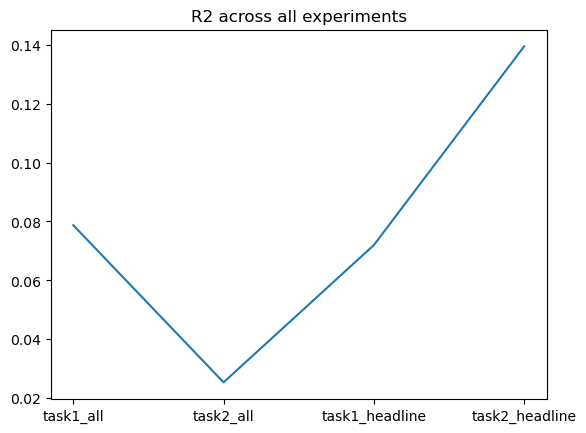

In [123]:

r2_scores = [r1[1], r2[1], r3[1], r4[1]]
x_axis = [1, 2, 3, 4]
plt.plot(x_axis, r2_scores)
plt.xticks([1, 2, 3, 4], ['task1_all',  'task2_all', 'task1_headline', 'task2_headline'])
plt.title('R2 across all experiments')


In [124]:
r2_scores

[0.07871246264624487,
 0.025353220412455912,
 0.0719598510423276,
 0.1394458499720307]

- Observe that in predicting the current month's return,the xgboost model has better performance when trained on the entire dataset compared to the headline-only dataset. 
- However in predicting the next month's return, the xgboost model has better performance when trained on the headline-only dataset compared to the entire dataset
- This suggests that the financial performance metrics are more useful for current month prediction, and the headline and sentiment information have a more delaying effect on the company's next month's stock return. 


In `stock_predict.ipynb`, I used the deep learning approach and build an encoder-decoder model for the same task for comparison.